# Encoding data into state coefficients

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #avoids conda Intel openmp polluting the matplotlib libraries

In [2]:
# Use nonlinear least squares to determine the coefficients of the states to encode the numerical vector data.
# Given the 2*num_qubits coefficients needed for each individual qubit, we solve f(x)=b, wherein the b is the 
# data to be encoded, x are the qubit coefficients, where a 1d array of length N holds N/2 qubits, with the 
#|0> and |1> states in alternating odd/even patterns, and f(x) is the kronecker producted coefficients of 
# these individual qubit pure states.
import numpy as np
import scipy.optimize

num_qubits = 2

#Function that computes the kronecker product of each individual qubit, and returns an array with each state coeff
def func(x):
    qubits = []
    for ii in range(0,len(x),2):
        qubits.append(np.array([x[ii],x[ii+1]]))
    coeffs = [1]
    for ii in range(0,len(x)//2):
        coeffs = np.kron(coeffs, qubits[ii])
    return np.array(coeffs)

#f(x) - b = 0 to be solved
def nl_eqs(x, *rhs):
    res = func(x)-rhs/np.linalg.norm(rhs)
    return res

#Vector data to encode
data_vals = [3.42, 1.24, 1.97, 0.72] #np.ones(2**num_qubits)

#Initial values for the qubits. 
qubit_init_coeff = 1/(np.sqrt(2))*np.ones(2*num_qubits)

#Constrained NL LSQ, with coefficients between -1 and 1. Ignoring possibility of complex coefficients for simplicity
x = scipy.optimize.least_squares(nl_eqs, qubit_init_coeff, bounds=([-1,1]), args=data_vals).x
for ii in range(0,len(x),2):
    x[ii:ii+2] = x[ii:ii+2]/np.linalg.norm(x[ii:ii+2])
print(x)

[0.86632121 0.4994873  0.93989541 0.34146248]


Following the work of PRL 114 110504 (2015) we can achieve similar state coeffs by using the given data state. A choice of a different solver method can influence this, but multiplying the numbers and removing the normalisation factor allows us to recover the encoded data set. We can wrap the above method up into a function as follows.

In [3]:
def encoding_data(data_vec):
    #Ensure we have enough qubits to encode string, and pad if data is non power of 2
    dvec = np.array(data_vec)
    lg2_len = np.log2(len(dvec))
    required_qubits = np.ceil(lg2_len)
    num_qubits = int(required_qubits)
    if lg2_len != required_qubits:
        dz = np.zeros(2**num_qubits)
        dz[:dvec.shape[0]] = dvec
        dvec = dz

    #Assign initial values
    qubit_init_coeff = 1/(np.sqrt(2))*np.ones(2*num_qubits)
    #Perform NLLSQ
    x =  scipy.optimize.least_squares(nl_eqs, qubit_init_coeff, bounds=([-1,1]), args=dvec).x
    
    #Ensure the resulting states are normalised according to each qubit's coefficients
    for ii in range(0,len(x),2):
        x[ii:ii+2] = x[ii:ii+2]/np.linalg.norm(x[ii:ii+2])
    return x
    

In [4]:
y = encoding_data([0.5,0.5,0.9,0.1])

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, QuantumCircuit, execute, Aer, IBMQ, compile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

u_backend = BasicAer.get_backend('unitary_simulator')
num_samples = 20000

/Users/mlxd/workspace/quantum/duqt/install/duqt_conda/envs/duqt/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


Examine the encoding of data into a single qubit first. Extract the unitary evolution matrix corresponding with a R_y(2*theta) rotation to place the qubit into the appropriate state


In [6]:
q = QuantumRegister(1)            
rot_circ = QuantumCircuit(q)
rot_circ.ry(2*np.arccos(x[ii]), q[0])

job = execute(rot_circ, u_backend)
u_mat = job.result().get_unitary(rot_circ, decimals=3)
print("U matrix:= ")
print (u_mat)
print("Applying matrix to state |0> = [1,0]^T")
print (np.matmul(u_mat, [1, 0]))

U matrix:= 
[[ 0.94 +0.j -0.341+0.j]
 [ 0.341+0.j  0.94 +0.j]]
Applying matrix to state |0> = [1,0]^T
[0.94 +0.j 0.341+0.j]


/Users/mlxd/workspace/quantum/duqt/install/duqt_conda/envs/duqt/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


Now that we can encode data into a single qubit, we can encode the full vector data into the entire register as follows. We begin by defining the starting location of the GHZ state we wish to encode data into. For that, we need to examine the control qubit (0) and apply a controlled R_y operation if it is set, to ensure the test data is set into state |00> and the reference data in state |11>.

In [7]:
# In memory DB for storing values
import sqlite3
if 'conn' in globals():
    conn.close()
conn = sqlite3.connect(':memory:')
# Get a cursor object
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE q_states(id INTEGER PRIMARY KEY, state_key TEXT,
                       dtheta REAL, counts INTEGER)
''')

In the next step, we compare two vectors, wherein one of the two is rotated through an angle from 0 to 2Pi. The resulting counts are recorded into the previously created database, with the correspodning angle and state label.

In [8]:
for th in np.linspace(0, 2*np.pi, 100, endpoint=True):
    #Prepare the GHZ state on qubits 1,2, and use 0 as the control qubit for Rotations
    q = QuantumRegister(2); #Entangled state for storing vectors
    a = QuantumRegister(1); #Ancililary qubit for measurements
    c_a = ClassicalRegister(1); #Classical measurement from anciliary qubit
    c_q = ClassicalRegister(2); #C measurement on rest of qubit

    ghz_circ = QuantumCircuit(a, q, c_a, c_q);

    ghz_circ.h(a[0]);           
    #ghz_circ.cx(a[0], q[0]);
    #ghz_circ.cx(a[0], q[1]);


    #Encode the data to test
    x = [1,0,1,0]
    y = [np.cos(th),np.sin(th),np.cos(th),np.sin(th)]
    for ii in range(0,len(x),2):
        ghz_circ.cu3(2*np.arccos(x[ii]), 0, 0, a[0], q[ii//2])
        #ghz_circ.crz(2*np.arccos(x[ii]), a[0], q[ii//2])

    #Next, encode the reference data by flipping the first bit to allow it into the |11> state
    ghz_circ.x(a[0])
    for ii in range(0,len(x),2):
        ghz_circ.cu3(2*np.arccos(y[ii]), 0, 0, a[0], q[ii//2])
        #ghz_circ.crz(2*np.arccos(x[ii]), a[0], q[ii//2])

    #Extract result from anciliary qubit measurement
    m_anc = 0
    m_q = 1
    if m_anc:
        ghz_circ.measure(a, c_a)
        backend = Aer.get_backend('qasm_simulator')
        qobj = compile(ghz_circ, backend, shots=num_samples)
        job = backend.run(qobj)
        result = job.result()
        counts = result.get_counts()
        print(counts)

    if m_q:
        ghz_circ.measure(q, c_q)
        backend = Aer.get_backend('qasm_simulator')
        qobj = compile(ghz_circ, backend, shots=num_samples)
        job = backend.run(qobj)
        result = job.result()
        counts = result.get_counts()
        print(counts)

    #Store the results into an in-memory sqlite DB
    for k,v in counts.items():
        cursor.execute('''INSERT INTO q_states(state_key, dtheta, counts) VALUES(?,?,?)''', 
                       (k, th, v))
    conn.commit()

{'00 0': 20000}
{'01 0': 44, '00 0': 19920, '10 0': 36}
{'01 0': 134, '00 0': 19712, '10 0': 152, '11 0': 2}
{'01 0': 384, '00 0': 19235, '10 0': 367, '11 0': 14}
{'01 0': 573, '00 0': 18765, '10 0': 618, '11 0': 44}
{'01 0': 840, '00 0': 18210, '10 0': 851, '11 0': 99}
{'01 0': 1209, '00 0': 17436, '10 0': 1192, '11 0': 163}
{'01 0': 1492, '00 0': 16697, '10 0': 1494, '11 0': 317}
{'01 0': 1799, '00 0': 15840, '10 0': 1755, '11 0': 606}
{'01 0': 2016, '00 0': 15054, '10 0': 2031, '11 0': 899}
{'01 0': 2283, '00 0': 14219, '10 0': 2200, '11 0': 1298}
{'01 0': 2440, '00 0': 13387, '10 0': 2447, '11 0': 1726}
{'01 0': 2481, '00 0': 12754, '10 0': 2541, '11 0': 2224}
{'01 0': 2530, '00 0': 12076, '10 0': 2404, '11 0': 2990}
{'01 0': 2365, '00 0': 11631, '10 0': 2368, '11 0': 3636}
{'01 0': 2219, '00 0': 11203, '10 0': 2159, '11 0': 4419}
{'01 0': 2007, '00 0': 10750, '10 0': 2029, '11 0': 5214}
{'01 0': 1718, '00 0': 10481, '10 0': 1702, '11 0': 6099}
{'01 0': 1417, '00 0': 10302, '10 0':

In [9]:
#Extract the unique state labels and angles for plotting
cursor.execute('''SELECT DISTINCT state_key FROM q_states ''')
uniq_states = [s[0] for s in cursor.fetchall()]
cursor.execute('''SELECT DISTINCT dtheta FROM q_states ''')
angles = [s[0] for s in cursor.fetchall()]


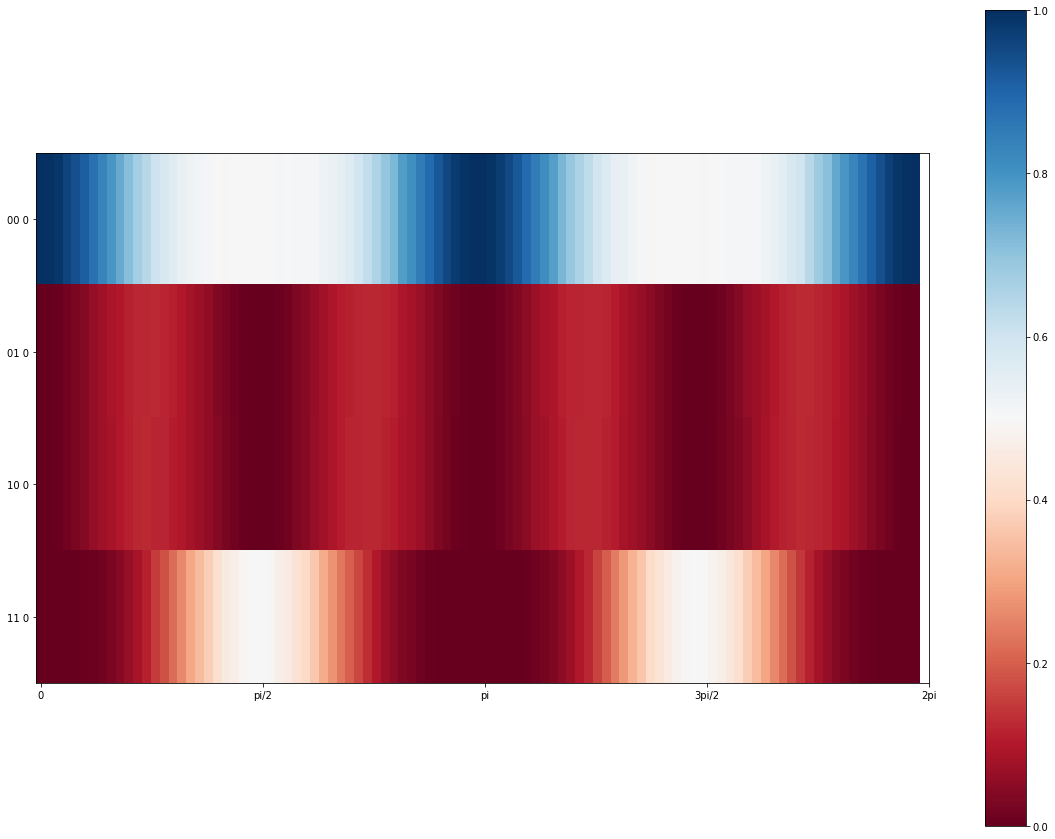

In [10]:
#Extract the appropriate data from the DB and plot the results
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

counts = np.zeros((len(uniq_states), len(angles)));
for c_jj, v_jj in enumerate(uniq_states):
    for c_ii, v_ii in enumerate(angles):
        cursor.execute('''SELECT counts, state_key, dtheta FROM q_states WHERE dtheta=? AND state_key=?''', (v_ii, v_jj,) )
        all_rows = cursor.fetchall()
        for row in all_rows:
            counts[c_jj][c_ii] = row[0];
            
plt.rcParams['figure.figsize'] = [20, 15]
fig, ax = plt.subplots()
im = ax.imshow(counts/num_samples, cmap='RdBu')
ax.set_aspect(15)
plt.xticks([i*16 for i in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]], ['0', 'pi/2', 'pi', '3pi/2', '2pi'])
plt.yticks(np.arange(len(uniq_states)), uniq_states)
cbar = ax.figure.colorbar(im)

As the vector is rotated through a variety of angles relative to the reference, we can see occupation of the |00> state (which is 100% at dtheta=0), lessens, and states |01> and |10> have non-negligible counts. As the vector is rotated to $\pi/2$, the occupation of the |01> and |10> drops off, and the |11> state approaches 50%, along with |00>. This implies that the states are now maximally entangled, in state (|00> + |11>)/(sqrt(2)), with further rotations causing an oscillation through these propbabilities back to the original states.

As such, when the vector as the same, P(|00>) = 100% P(all others) = 0%, and when they are orthogonal P(|00>) =50% and P(|11>)=50%.

Measuring the anciliary bit as implied by PRL 114, 110504 (2015) however does not allow us to extract any information, as measurements of the full state is required. 

In [11]:
for c_jj, v_jj in enumerate(uniq_states):
    for c_ii, v_ii in enumerate(angles):
        cursor.execute('''SELECT counts, state_key, dtheta FROM q_states WHERE dtheta=? AND state_key=?''', (v_ii, v_jj,) )
        all_rows = cursor.fetchall()
        for row in all_rows:
            counts[c_jj][c_ii] = row[0];

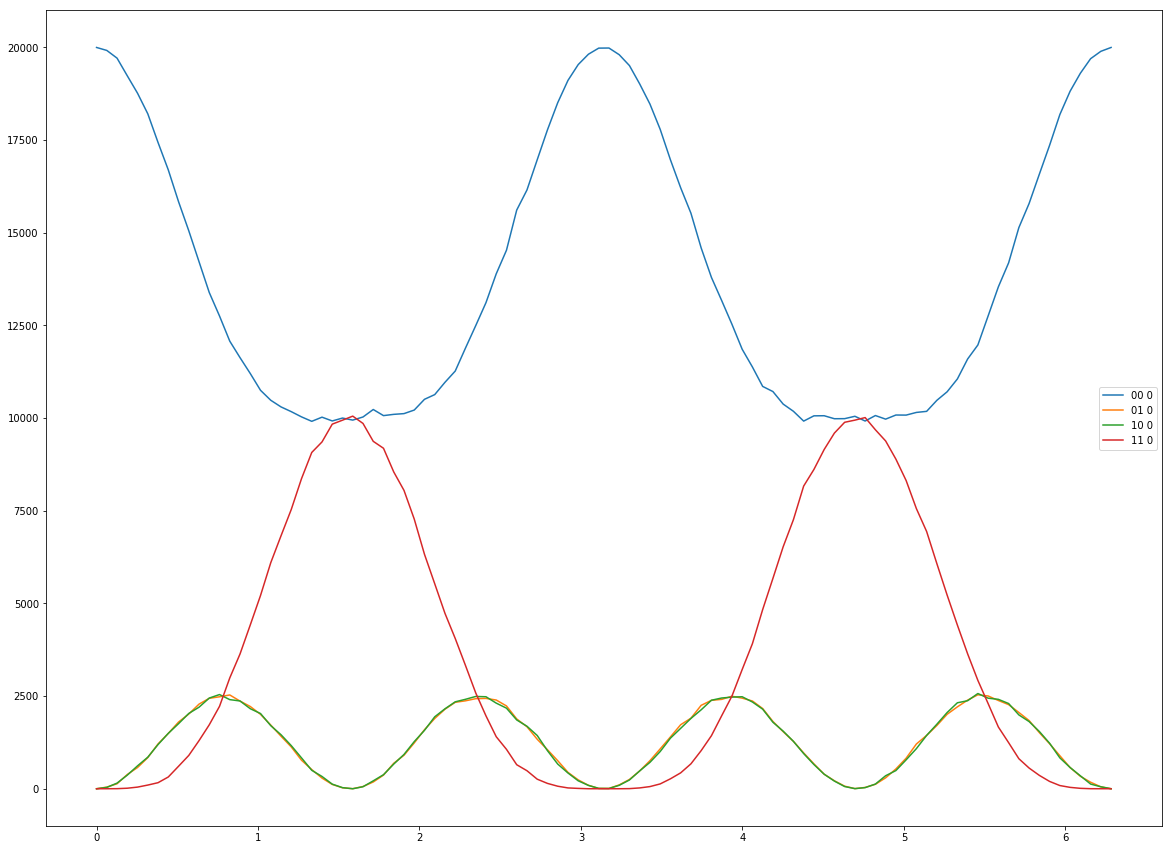

In [13]:
for c_jj, v_jj in enumerate(uniq_states):
    plt.plot(angles, counts[c_jj][:])
    plt.legend(uniq_states)